# MEF en 2D

Nota: a este documento no lo podremos ejecutar de manera dinámica con Binder, sólo lo podrán correr si tienen instalado:

- Python 3.5 o más nuevo instalado.
- [Jupyter Notebook](https://jupyter.readthedocs.io/en/latest/install.html).
- [FEniCS](https://fenicsproject.org/).

### Referencias
- Mark S. Gockenbach, [Understanding and Implementing the Finite Element Method](https://my.siam.org/Store/Product/viewproduct/?ProductId=997) (2006), Siam.

### Código en FEniCS

Ejecutar este documento en forma dinámica: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rirastorza/Intro2FEM/blob/master/Elementos_finitos_en_2D/fem2D.ipynb)


Para correr en google colab ejecutar la siguientes instrucciones (https://fem-on-colab.github.io/).


In [ ]:
%%capture  
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Introducción y definiciones

Hemos estudiado la [**la ecuación de Poisson**](https://es.wikipedia.org/wiki/Ecuaci%C3%B3n_de_Poisson) para introducir la solución por el Método de Elementos Finitos (MEF) en una dimensión. En este tutorial continuaremos con este ejemplo, poniendo especial atención a las cosas que se modifican en dos dimensiones.

$$ \left \{ \begin{array}{l} - \triangle u = f \ \ \text{ en } \ \ \Omega \\   u=0  \ \ \text{en} \ \ \partial\Omega_{1} \ \ \text{(Dirichlet)}\\   \frac{\partial u}{\partial n}=h  \ \ \text{en} \ \ \partial\Omega_{2} \ \ \text{(Neumann)}  \end{array} \right . \tag{1}$$

### Definiciones

En el caso que vamos a estudiar $u$ es un **campo escalar** en el plano que depende de $x$ e $y$. Ejemplo: en el problema térmico sería la temperatura.

#### La geometría la denotamos de la siguiente manera:

- $\Omega : $ Dominio en $\mathbb{R}^{2}$
- $\partial\Omega : $ Contorno o borde.
- $\overrightarrow{n} : $ vector unitario normal.

[<img src="figura1.png" width="250"/>](figura1.png)

#### Algunas cosas de cálculo vectorial

- El operador de Laplace o **Laplaciano** ($\triangle$) aplicado a $u$ queda:

$$\triangle u = \frac{\partial^{2} u}{\partial x^{2}}+\frac{\partial^{2} u}{\partial y^{2}}$$

Note que el resultado del operador Laplaciano es un **escalar**.

- El **gradiente** de $u$ lo definimos como:

$$ \nabla u \left(x,y \right) = \begin{bmatrix} \frac{\partial u}{\partial x} \\ \frac{\partial u}{\partial y} \end{bmatrix} \tag{2}$$

Note que el gradiente es un **campo vectorial**.

- El **vector normal** $\overrightarrow{n}\left(x,y\right)$ apunta hacia afuera del borde $\partial \Omega$ en el punto $\left(x,y\right)$.

- En el caso de la condición de borde de Neumann se utiliza **la derivada direccional**, se denota $\frac{\partial u}{\partial n}$ y se define de la siguiente manera:

$$\frac{\partial u}{\partial n} = \nabla u \cdot \overrightarrow{n}\tag{3}$$

esto es, el producto escalar entre el gradiente de $u$ y el versor normal. Conceptualmente me dice cómo cambia la función $u$ en la dirección dada por $\overrightarrow{n}$ (se generaliza el concepto de derivadas parciales porque éstas dan los cambios respecto de las direcciones $x$ e $y$). En la definición se ve que es la proyección del gradiente en la dirección normal.

- En esta unidad trataremos con campos vectoriales. Un ejemplo puede ser la tasa de flujo de calor ($\overrightarrow{q}=-k\nabla T$), que es un campo vectorial definido para cada posición $\left(x,y\right)$. Para un campo vectorial $\overrightarrow{F}$, definido como:

$$\overrightarrow{F} = \begin{bmatrix} F_{1}\left(x,y\right) \\ F_{2}\left(x,y\right) \end{bmatrix},$$

el **operador divergencia** ($\nabla \cdot$) aplicado a $\overrightarrow{F}$ se define como: 

$$\nabla \cdot \overrightarrow{F} = \frac{\partial F_{1}}{\partial x}+\frac{\partial F_{2}}{\partial y}.$$

Note que devuelve un escalar.

## Teorema de la divergencia e identidad de Green

Recordemos que para obtener la formulación variacional que podamos resolver con MEF debíamos bajar el órden de la derivada. Para esto, se integró por partes:

$$\int_{x_{1}}^{x_{2}}f_{1}f_{2}^{'}dx = \left. f_{1}f_{2} \ \ \right |_{x_{1}}^{x_{2}}- \int_{x_{1}}^{x_{2}}f_{1}^{'}f_{2}dx$$

llamando $f_{1}=v$ y $f_{2}=u^{'}$. En dos dimensiones esto es similar y debemos aplicar el **teorema de la divergencia** al campo vectorial como comentaremos a continuación.

### Teorema de la divergencia

Me relaciona dos cosas, lo que ocurre dentro de la geometría (en $\Omega$) con lo que sale (o entra) en los bordes de la misma ($\partial \Omega$). Si el dominio $\Omega$ en $\mathbb{R}^{2}$ tiene bordes suaves o suaves a trozo, el teorema de la divergencia establece el siguiente resultado:

$$\int_{\Omega} \nabla \cdot \overrightarrow{F} da = \int_{\partial \Omega} \overrightarrow{F} \cdot \overrightarrow{n} ds \tag{4}$$

En esta ecuación $da$ es un diferencial de área (integral doble) y $ds$ es un diferencial de arco (notemos que el término de la derecha es una integral de línea). 

Trataremos de reescribir este resultado para que nos sirva para nuestro propósito. Si elegimos:

$$\overrightarrow{F} = \begin{bmatrix} f\left(x,y\right) \\ 0 \end{bmatrix},$$

como el vector normal es: 

$$\overrightarrow{n} = \begin{bmatrix} n_{1} \\ n_{2} \end{bmatrix},$$

y aplicamos el teorema, llegamos a:

$$\int_{\Omega} \frac{\partial f}{\partial x} da = \int_{\partial \Omega} f \ n_{1} \ ds \tag{5}.$$

Por otro lado, si ahora elegimos:

$$\overrightarrow{F} = \begin{bmatrix} 0 \\ f\left(x,y\right) \end{bmatrix},$$

y aplicamos el teorema, llegamos a:

$$\int_{\Omega} \frac{\partial f}{\partial y} da = \int_{\partial \Omega} f \ n_{2} \ ds \tag{6}.$$

Ahora hacemos lo mismo pero tomando un producto de funciones $f\left(x,y\right) = h\left(x,y\right)g\left(x,y\right)$. Recordando la derivada del producto: $\frac{\partial f}{\partial x}= \frac{\partial h}{\partial x}g+h\frac{\partial g}{\partial x}$ (lo mismo para $y$). Reemplazamos en las Ecs. (5) y (6) y tenemos:

$$\int_{\Omega}  \frac{\partial h}{\partial x}g+h\frac{\partial g}{\partial x} da = \int_{\partial \Omega} hg \ n_{1} \ ds \Rightarrow \int_{\Omega}  \frac{\partial h}{\partial x}g da = \int_{\partial \Omega} hg \ n_{1} \ ds - \int_{\Omega} h\frac{\partial g}{\partial x} da \tag{7}$$

$$\int_{\Omega} \frac{\partial h}{\partial y}g+h\frac{\partial g}{\partial y} da = \int_{\partial \Omega} hg \ n_{2} \ ds\Rightarrow \int_{\Omega} h\frac{\partial g}{\partial y} da = \int_{\partial \Omega} hg \ n_{2} \ ds - \int_{\Omega} \frac{\partial h}{\partial y}g da \tag{8}.$$

Supongamos que $h=w_{i}$ es una de las componentes de un campo vectorial $\overrightarrow{W}$.

$$\overrightarrow{W} = \begin{bmatrix}w_{1} \\ w_{2} \end{bmatrix}$$

y $g = v $ (nuestra función de prueba). Reemplazamos en las Ec. (7):

$$\int_{\Omega}  \frac{\partial w_{1}}{\partial x}v da = \int_{\partial \Omega} w_{1}v \ n_{1} \ ds - \int_{\Omega} w_{1}\frac{\partial v}{\partial x} da,$$

ahora en Ec. (8):

$$\int_{\Omega} w_{2}\frac{\partial v}{\partial y} da = \int_{\partial \Omega} w_{2}v \ n_{2} \ ds - \int_{\Omega} \frac{\partial w_{2}}{\partial y}v da,$$

y las sumamos:

$$\int_{\Omega}  \frac{\partial w_{1}}{\partial x}v da +\int_{\Omega} w_{2}\frac{\partial v}{\partial y} da  = \int_{\partial \Omega} w_{1}v \ n_{1} \ ds - \int_{\Omega} w_{1}\frac{\partial v}{\partial x} da+\int_{\partial \Omega} w_{2}v \ n_{2} \ ds - \int_{\Omega} \frac{\partial w_{2}}{\partial y}v da$$

Las reordenamos:

$$\int_{\Omega}  \frac{\partial w_{1}}{\partial x}v da + \int_{\Omega} \frac{\partial w_{2}}{\partial y}v da = - \int_{\Omega} w_{1}\frac{\partial v}{\partial x}da -\int_{\Omega} w_{2}\frac{\partial v}{\partial y} da
  +\int_{\partial \Omega} w_{1}v \ n_{1} \ ds+\int_{\partial \Omega} w_{2}v \ n_{2} \ ds, $$

y lo reescribimos de forma vectorial:

$$\int_{\Omega} \left(\nabla \cdot \overrightarrow{W} \right)v da =- \int_{\Omega}\overrightarrow{W} \cdot \nabla v  da + \int_{\partial \Omega} v \overrightarrow{W}\cdot \overrightarrow{n}  ds.$$

Ahora cambiamos de nuevo, llamamos $\overrightarrow{W} = -\nabla u$ y nos queda:

$$\int_{\Omega} \left(\nabla \cdot \left(-\nabla u\right) \right)v da =- \int_{\Omega}\left( -\nabla u\right) \cdot \nabla v  da + \int_{\partial \Omega} v \left( -\nabla u\right)\cdot \overrightarrow{n}  ds.$$

Si notamos que la divergencia del gradiente es el laplaciano, me queda:

$$-\int_{\Omega}  \triangle u \ v da = \int_{\Omega}\nabla u \ \cdot \nabla v  da - \int_{\partial \Omega} v \underbrace{\nabla u \cdot \overrightarrow{n}}_{\text{derivada direccional}}  ds. \tag{9}$$

Hemos llegado a la ecuación (se denomina primer [identidad de Green](https://es.wikipedia.org/wiki/Identidades_de_Green)) que nos sirve para bajar el orden de la derivada y vincular las condiciones de borde en la **formulación variacional**.

## Ejemplo de campo escalar térmico en una placa

En lo que sigue, implementaremos la [ecuación de Laplace](https://es.wikipedia.org/wiki/Ecuaci%C3%B3n_de_Laplace) en un dominio cuadrado ($\Omega$) con condiciones de borde Dirichlet cero en todos lados ($\partial \Omega_{1}$) menos a la derecha que vale 5 ($\partial \Omega_{2}$).

$$ \left \{ \begin{array}{l} - \triangle u = 0 \ \ \text{ en } \ \ \Omega \\   u=0  \ \ \text{en} \ \ \partial\Omega_{1} \ \ \text{(Dirichlet)}\\   u=5  \ \ \text{en} \ \ \partial\Omega_{2} \ \ \text{(Dirichlet)}  \end{array} \right . \tag{10}$$

### Formulación variacional

Hacemos lo mismo de siempre, multiplicamos por la función de prueba $v$ e integramos.

$$\int_{\Omega}- \triangle u v da = 0, $$

aplicamos la Ec. (9) y se obtiene:

$$\int_{\Omega}- \triangle u v da=\int_{\Omega}\nabla u \ \cdot \nabla v  da - \int_{\partial \Omega} v \nabla u \cdot \overrightarrow{n}  ds. $$

Por lo tanto nos queda:

$$\int_{\Omega}\nabla u \ \cdot \nabla v  da - \int_{\partial \Omega} v \nabla u \cdot \overrightarrow{n}  ds=0 .$$

Elegimos convenientemente $v$ de tal forma que se anule en los bordes $\partial \Omega_{1}$ y valga 5 en $\partial \Omega_{2}$ y nos queda:

$$\int_{\Omega}\nabla u \ \cdot \nabla v  da =\int_{\Omega} f \ v \ da. \tag{11}$$

esto vale para todo $v$ perteneciente al espacio de funciones $V$.

Tendriamos que recorrer los mismos pasos que hicimos con el problema en 1D. Nosotros lo resolveremos utilizando FEniCS.

### Algunas conclusiones

- Si encontramos la solución de la Ec. (11), no implica que sea solución de la Ec. (10), pero si lo es de ésta última también lo será de la primera. Por eso a la Ec. (11) se le dice **formulación débil** y a la (10) **fuerte**.
- Ahora deberíamos construir funciones sombrero ($\varphi_{i}$), pero en dos dimensiones. No lo haremos, pasaremos directo a FEniCS.


### Código

Utilizamos una malla nativa con la función *UnitSquareMesh* (genera una malla cuadrada de lado 1), se le pasan la cantidad de nodos deseados. Creamos también las funciones para definir los bordes (de manera similar a como hemos venido trabajando). Explicado en el **ejemplo10.py**

In [6]:
from fenics import *
mesh = UnitSquareMesh(30, 30)
V = FunctionSpace(mesh, 'CG',1)#Continuous Lagrange elements

def borde_D(x, on_boundary): 
    tol = 1.E-14
    return on_boundary and near(x[0], 1., tol)

bc_der=DirichletBC(V, Constant(5.0), borde_D)

def borde_I(x, on_boundary):
    tol = 1.E-14
    return on_boundary and near(x[0], 0., tol)

bc_iz = DirichletBC(V, Constant(0.0), borde_I)

def borde_AB(x, on_boundary):
    tol = 1.E-14
    return on_boundary and near(x[1], 0., tol)

bc_abajo = DirichletBC(V, Constant(0.0), borde_AB)

def borde_AR(x, on_boundary):
    tol = 1.E-14
    return on_boundary and near(x[1], 1., tol)

bc_arriba = DirichletBC(V, Constant(0.0), borde_AR)

bc = [bc_iz, bc_der, bc_arriba, bc_abajo]

Para definir la formulación variacional lo haremos de una forma ligeramente distinta, para mostrar las funciones de FEniCS: *lhs* y *rhs*. FEniCS detecta solo la forma bilineal y lineal $a(u,v) = L (v)$.

In [7]:
u = TrialFunction(V) 
v = TestFunction(V)
f = Constant(0.0)

F = dot(grad(u), grad(v))*dx-f*v*dx
a = lhs(F)
L = rhs(F) 

Podemos también ver la matriz de rigidéz y el vector de carga:

In [8]:
A = assemble(a)
A_array = A.array()
print('Matriz de rigidéz: ',A_array)
b = assemble(L)
print('Vector de carga: ',b.get_local())

Matriz de rigidéz:  [[ 1.  -0.5 -0.5 ...  0.   0.   0. ]
 [-0.5  2.   0.  ...  0.   0.   0. ]
 [-0.5  0.   2.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  2.   0.  -0.5]
 [ 0.   0.   0.  ...  0.   2.  -0.5]
 [ 0.   0.   0.  ... -0.5 -0.5  1. ]]
Vector de carga:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 

Ahora resuelvo y grafico. Vamos a dibujar con paraview.

In [9]:
#Resuelvo
u = Function(V)
solve(a == L, u, bc)
vtkfile_T = File('temperatura.pvd')
vtkfile_T << u

Solving linear variational problem.


También se puede calcular el gradiente, pero tengamos en cuenta que esto será un campo vectorial.

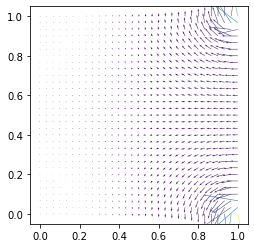

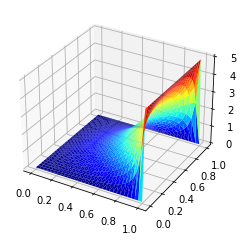

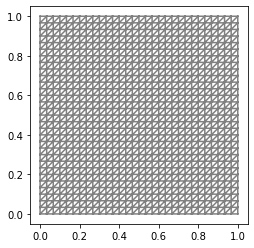

PETSc


In [10]:
V = u.function_space() #Tomo el espacio donde vive u
mesh = V.mesh()#su malla tambien
degree = V.ufl_element().degree() #el elemento finito
W = VectorFunctionSpace(mesh, 'CG', degree) #y creo un espacio con los mismos elementos de u

grad_u = project(grad(u), W) #Realizo la proyeccion
k = Constant(1.0)
flux_u = project(-k*grad(u), W)

vtkfile_Q = File('calor.pvd')
vtkfile_Q << flux_u

import matplotlib.pyplot as plt

plt.figure(1)
plot(flux_u)

plt.figure(2)
plot(u.root_node())

plt.figure(3)
plot(mesh)


plt.show()

#Imprime el solver: en este caso PETSc built in LU solver
print(parameters['linear_algebra_backend'])